In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
import argparse
from models import NEGA
from graph_generation import generate_graphs_and_states
from torch_geometric.utils.convert import to_networkx
import os
from tqdm import tqdm

# ladder grid trees erdos_renyi barabasi_albert 4-community
args = argparse.Namespace(  graph_type='erdos_renyi', 
                            input_dim=1,
                            hidden_dim=32, 
                            lr=0.0005,
                            layers=1,
                            epochs=30, 
                            n_samples_train=100,
                            n_nodes_train=20,
                            n_samples_val=5, 
                            n_nodes_val=20,
                            n_samples_test=5,
                            n_nodes_test=100, 
                          )

/home/anxing/anaconda3/envs/nega/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Reachability:  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
         0., 0.],
        [1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
         1., 1.]])


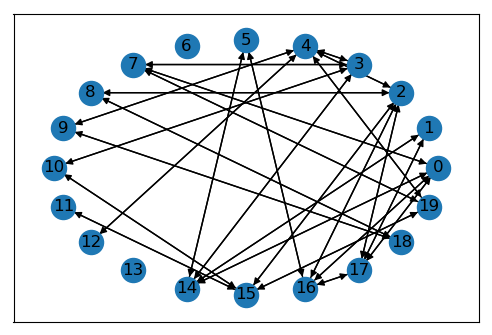

In [2]:
# generate training graphs and states of Reachability
train_graphs, train_states = generate_graphs_and_states(args.n_samples_train, args.n_nodes_train ,args.graph_type)
# generate validation graphs and states of Reachability
val_graphs, val_states = generate_graphs_and_states(args.n_samples_val, args.n_nodes_val ,args.graph_type)
graph = to_networkx(train_graphs[0])
plt.figure(figsize=(6,4))
pos=nx.circular_layout(graph)
print("Reachability: ", train_states[0])
nx.draw_networkx(graph, pos=pos)


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
#create model
model = NEGA(args.input_dim, args.hidden_dim, args.layers).to(device)
print(model)

NEGA(
  (encoder): Encoder(
    (w): Linear(in_features=33, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (l1): Linear(in_features=64, out_features=32, bias=True)
    (l2): Linear(in_features=32, out_features=32, bias=True)
    (relu): ReLU()
    (out): Linear(in_features=32, out_features=1, bias=True)
    (sig): Sigmoid()
  )
  (processor_net): GAT(
    (relu): ReLU()
    (GATConv): ModuleList(
      (0): GATConv(32, 32, heads=1)
    )
  )
  (termination_net): T_Net(
    (w): Linear(in_features=32, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)


In [4]:
optimizer = optim.Adam(model.parameters(), lr=args.lr)
schedualr = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
criteria = nn.BCELoss()
best_model = None
best_accuracy = 0
k1 = 1
k2 = 1

# training process
for i in tqdm(range(args.epochs)):
    training_losses = []
    model.train()
    for graph, states in zip(train_graphs,train_states):
        edge_index, features  = graph.edge_index.to(device), graph.x.to(device) 
        states = states.to(device)
        N = features.shape[0]
        h = torch.zeros(N, args.hidden_dim).to(device)
        num_nodes = len(features)
        features=features.unsqueeze(dim=1)
        loss = []
        for j in range(num_nodes):
            optimizer.zero_grad()
            out,t, h = model(features, h, edge_index)
            stop = 0
            if len(states) - 1 == j:
                stop = 1
            features = (out > .5).to(int)
            target= states[j]
            out = out.squeeze(1)
            loss_class = criteria(out,target)
            termination = torch.tensor(stop).to(device).unsqueeze(0)
            loss_terminate = criteria(t,termination.float())
            loss_total = k1*loss_class + k2*loss_terminate
            loss_total.backward()
            optimizer.step()
            schedualr.step()
            h = h.detach()
            features = features.detach()
            loss.append(loss_total.item())
            if stop == 1:
                break
        mean_loss = np.mean(loss)
        training_losses.append(mean_loss)

    # val process
    all_accuracy = []
    last = []
    model.eval()
    with torch.no_grad():
        for graph, states in zip(val_graphs, val_states):
            edge_index, features  = graph.edge_index.to(device), graph.x.to(device) 
            states = states.to(device)
            N = features.shape[0]
            h = torch.zeros(N, args.hidden_dim).to(device)
            v = len(features)
            features=features.unsqueeze(dim=1)
            accuracies = []
            for k in range(v):
                out,t, h = model(features, h, edge_index)
                stop = 0
                if len(states)-1 == k:
                    stop = 1
                features = ( out > .5).to(int)
                target= states[k]
                out =( out > .5).to(int)
                out = out.squeeze(1)
                accuracy = torch.sum(out == target) / len(out)
                accuracies.append(accuracy.item())
                if stop ==1:
                    break
            accuracy = np.mean(accuracies)
            all_accuracy.append(accuracy)
            last.append(accuracies[-1])
    average_accu=np.mean(all_accuracy)
    last_accu = np.mean(last)
    loss_mean = np.mean(training_losses)
    tqdm.write(f" loss (Training) {loss_mean:.3f} | Average Accuracy (Val) {average_accu*100:.3f} | Last Accuracy (Val) {last_accu*100:.3f} ")
    if best_accuracy < average_accu:
        model_name = 'model.pt'
        if not os.path.isdir('./models_checkpoints'):
            os.mkdir('./models_checkpoints')
        path_save= os.path.join('./models_checkpoints',model_name)
        torch.save(model.state_dict(), path_save)

        best_accuracy = average_accu

  3%|▎         | 1/30 [00:06<03:16,  6.78s/it]

 loss (Training) 1.197 | Average Accuracy (Val) 83.200 | Last Accuracy (Val) 99.000 


  7%|▋         | 2/30 [00:11<02:39,  5.71s/it]

 loss (Training) 0.699 | Average Accuracy (Val) 83.200 | Last Accuracy (Val) 99.000 


 10%|█         | 3/30 [00:16<02:26,  5.41s/it]

 loss (Training) 0.642 | Average Accuracy (Val) 83.200 | Last Accuracy (Val) 99.000 


 13%|█▎        | 4/30 [00:21<02:16,  5.24s/it]

 loss (Training) 0.615 | Average Accuracy (Val) 83.200 | Last Accuracy (Val) 99.000 


 17%|█▋        | 5/30 [00:26<02:09,  5.17s/it]

 loss (Training) 0.607 | Average Accuracy (Val) 83.200 | Last Accuracy (Val) 99.000 


 20%|██        | 6/30 [00:31<02:02,  5.11s/it]

 loss (Training) 0.596 | Average Accuracy (Val) 83.200 | Last Accuracy (Val) 99.000 


 23%|██▎       | 7/30 [00:36<01:56,  5.06s/it]

 loss (Training) 0.585 | Average Accuracy (Val) 83.200 | Last Accuracy (Val) 99.000 


 27%|██▋       | 8/30 [00:41<01:50,  5.04s/it]

 loss (Training) 0.577 | Average Accuracy (Val) 83.200 | Last Accuracy (Val) 99.000 


 30%|███       | 9/30 [00:46<01:45,  5.04s/it]

 loss (Training) 0.533 | Average Accuracy (Val) 85.400 | Last Accuracy (Val) 99.000 


 33%|███▎      | 10/30 [00:51<01:39,  4.95s/it]

 loss (Training) 0.437 | Average Accuracy (Val) 94.300 | Last Accuracy (Val) 99.000 


 37%|███▋      | 11/30 [00:56<01:34,  4.96s/it]

 loss (Training) 0.356 | Average Accuracy (Val) 95.750 | Last Accuracy (Val) 99.000 


 40%|████      | 12/30 [01:01<01:29,  4.98s/it]

 loss (Training) 0.349 | Average Accuracy (Val) 96.050 | Last Accuracy (Val) 99.000 


 43%|████▎     | 13/30 [01:06<01:24,  4.97s/it]

 loss (Training) 0.324 | Average Accuracy (Val) 96.150 | Last Accuracy (Val) 99.000 


 47%|████▋     | 14/30 [01:11<01:19,  4.99s/it]

 loss (Training) 0.335 | Average Accuracy (Val) 95.700 | Last Accuracy (Val) 99.000 


 50%|█████     | 15/30 [01:16<01:15,  5.01s/it]

 loss (Training) 0.330 | Average Accuracy (Val) 97.350 | Last Accuracy (Val) 99.000 


 53%|█████▎    | 16/30 [01:21<01:10,  5.02s/it]

 loss (Training) 0.288 | Average Accuracy (Val) 95.900 | Last Accuracy (Val) 99.000 


 57%|█████▋    | 17/30 [01:26<01:05,  5.02s/it]

 loss (Training) 0.319 | Average Accuracy (Val) 97.300 | Last Accuracy (Val) 100.000 


 60%|██████    | 18/30 [01:31<01:00,  5.03s/it]

 loss (Training) 0.270 | Average Accuracy (Val) 97.950 | Last Accuracy (Val) 100.000 


 63%|██████▎   | 19/30 [01:36<00:55,  5.02s/it]

 loss (Training) 0.305 | Average Accuracy (Val) 97.350 | Last Accuracy (Val) 100.000 


 67%|██████▋   | 20/30 [01:41<00:50,  5.02s/it]

 loss (Training) 0.296 | Average Accuracy (Val) 97.000 | Last Accuracy (Val) 100.000 


 70%|███████   | 21/30 [01:46<00:45,  5.01s/it]

 loss (Training) 0.256 | Average Accuracy (Val) 97.750 | Last Accuracy (Val) 100.000 


 73%|███████▎  | 22/30 [01:51<00:40,  5.02s/it]

 loss (Training) 0.282 | Average Accuracy (Val) 97.950 | Last Accuracy (Val) 100.000 


 77%|███████▋  | 23/30 [01:56<00:35,  5.02s/it]

 loss (Training) 0.309 | Average Accuracy (Val) 97.950 | Last Accuracy (Val) 100.000 


 80%|████████  | 24/30 [02:01<00:30,  5.02s/it]

 loss (Training) 0.425 | Average Accuracy (Val) 96.150 | Last Accuracy (Val) 99.000 


 83%|████████▎ | 25/30 [02:06<00:25,  5.03s/it]

 loss (Training) 0.397 | Average Accuracy (Val) 97.150 | Last Accuracy (Val) 99.000 


 87%|████████▋ | 26/30 [02:11<00:20,  5.03s/it]

 loss (Training) 0.327 | Average Accuracy (Val) 96.100 | Last Accuracy (Val) 99.000 


 90%|█████████ | 27/30 [02:16<00:15,  5.04s/it]

 loss (Training) 0.383 | Average Accuracy (Val) 87.500 | Last Accuracy (Val) 99.000 


 93%|█████████▎| 28/30 [02:22<00:10,  5.05s/it]

 loss (Training) 0.368 | Average Accuracy (Val) 97.350 | Last Accuracy (Val) 99.000 


 97%|█████████▋| 29/30 [02:27<00:05,  5.05s/it]

 loss (Training) 0.354 | Average Accuracy (Val) 88.200 | Last Accuracy (Val) 99.000 


100%|██████████| 30/30 [02:32<00:00,  5.07s/it]

 loss (Training) 0.360 | Average Accuracy (Val) 97.300 | Last Accuracy (Val) 100.000 


In [9]:
model_path = './models_checkpoints/model.pt'
model.load_state_dict(torch.load(model_path))
# ladder trees grid erdos_renyi barabasi_albert 4-community
test_graphs, test_states = generate_graphs_and_states(n_sample=10, n_nodes=500, graph_type='ladder')
accuracy_target = []
accuracy_last = []
model.eval()
for graph_no, (graph, states) in enumerate(zip(test_graphs,test_states)):
    edge_index, features  = graph.edge_index.to(device), graph.x.to(device) 
    states = states.to(device)
    N = features.shape[0]
    h = torch.zeros(N, args.hidden_dim).to(device)
    v = len(features)
    features=features.unsqueeze(dim=1)
    accuracies = []
    for i in range(v):
        out,t, h = model(features, h, edge_index)
        stop = 0
        if len(states)-1 == i:
            stop = 1
        features = (out > .5).to(int)
        target= states[i]
        out =( out > .5).to(int)
        out = out.squeeze(1)
        accuracy = torch.sum(out == target) / len(out)
        accuracies.append(accuracy.item())
        if stop ==1:
            break
        if t.item() > .5:
                break
    a = np.mean(accuracies)
    l = accuracies[-1]
    accuracy_target.append(a)
    accuracy_last.append(l)
all_average = np.mean(accuracy_target)
all_last = np.mean(accuracy_last)
print(f'Average Accuracy and Last Accuracy Across All Graphs {all_average:.4f} | {all_last:.4f}')


Average Accuracy and Last Accuracy Across All Graphs 0.9233 | 0.0520
